In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import logging
logging.getLogger('tensorflow').disabled = True


import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

import tensorflow as tf
import tensorflow_probability as tfp

import transport_nets as tn

from transport_nets.models.NVP import NVP
from transport_nets.bijectors import BananaMap, BananaFlow
from transport_nets.mcmc import MetropolisHastings, model_log_prob

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

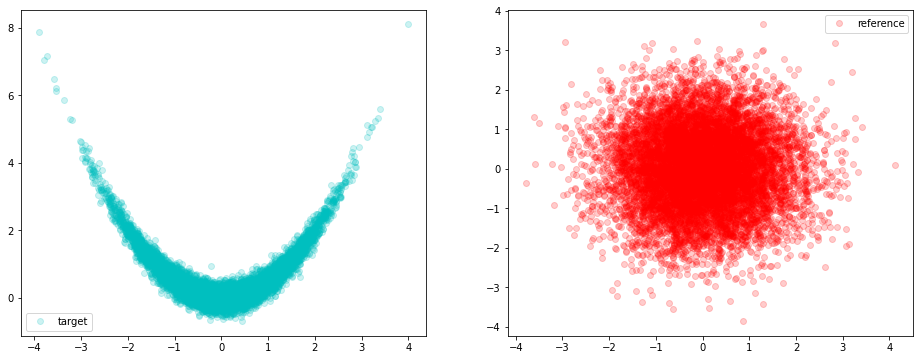

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 10000
bMap = BananaMap((1.0,0.5,0.2,0.0))
bFlow = BananaFlow(bMap)
target = bFlow.sample(num_samples)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
fig,ax = plt.subplots(1,2,figsize=(16, 6))
ax[0].plot(target[:,0], target[:,1], 'co', alpha = .2,label='target')
ax[0].legend()
ax[1].plot(latent[:,0], latent[:,1], 'ro', alpha = .2,label='reference')
ax[1].legend();

### Define an NVP-based normalizing flow

In [3]:
# Create model object
nvp = NVP(num_layers=2, neuron_list=[15,15])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-08)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

### Print a summary of the model

In [4]:
nvp.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 608
Trainable params: 608
Non-trainable params: 0
_________________________________________________________________


### Train the model using ADAM

In [5]:
# Define training options
n_epochs = 50
batch_size = 400

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs, verbose=0, callbacks=[TqdmCallback(verbose=1)])  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

### Plot the training history

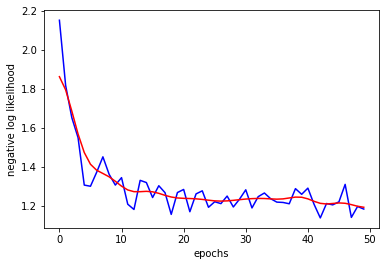

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('epochs')
plt.ylabel('negative log likelihood');

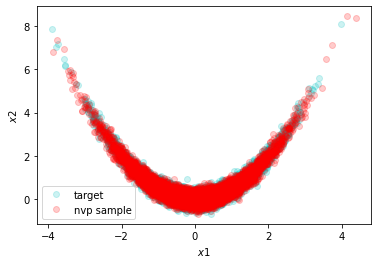

In [7]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(target[:,0], target[:,1], 'co', alpha = .2,label='target')
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2,label='nvp sample')
plt.xlabel('$x1$')
plt.ylabel('$x2$')
plt.legend();

## Conditional Sampling using Metropolis Hastings

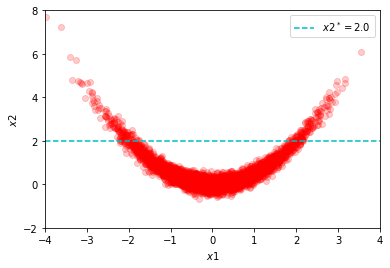

In [8]:
# We want to draw condition samples from about y = 0.0
x2_star = 2.0

fig, ax = plt.subplots()
forward_pass = nvp(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
ax.axhline(y=x2_star, color='c', linestyle='--',label='$x2^* = 2.0$')
ax.set(xlim=(-4,4),ylim=(-2,8))
ax.set(xlabel='$x1$',ylabel='$x2$')
plt.legend();

In [9]:
# Run the algorithm
init_val = tf.zeros([1],tf.float32)
b = tf.constant(2.0,tf.float32)
niters = 15000
y_given = tf.constant([2.0])
log_prob_fn = model_log_prob(nvp,y_given=y_given)

acc_rate, samples = MetropolisHastings(init_val,b,niters,log_prob_fn)
print('acceptance rate: %0.3f'%acc_rate)

100%|██████████| 15000/15000 [01:24<00:00, 176.95it/s]

acceptance rate: 0.082


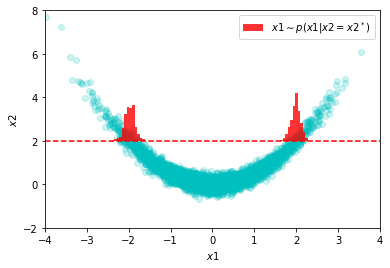

In [10]:
# Plot the conditional samples
fig, ax = plt.subplots()
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'co', alpha=.2)
ax.hist(samples[:,0], 100, (-3, 3), color='r', alpha=.8, density=True, zorder=10,bottom=2.0,label='$x1 \sim p(x1|x2=x2^*)$')
ax.axhline(y=x2_star, color='r', linestyle='--')
ax.set(xlim=(-4,4),ylim=(-2,8))
ax.set(xlabel='$x1$',ylabel='$x2$')
plt.legend();